# Task 2 : Building the baseline model

In [21]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dropout, Input, Flatten, Dense, MaxPooling2D
import matplotlib.pyplot as plt
from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline

In [22]:
# constants
img_height = img_width = 128
batch_size = 32
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'



### 1. Set up the classification

In [23]:

# Set random seeds for reproducibility
np.random.seed(123)  
tf.random.set_seed(123) 

# evaluation metrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),  # Accuracy metric
    tf.keras.metrics.AUC(name='auc')  # Area Under Curve metric
]

### 2. Build initial model


In [24]:
# Step 2: Build Initial Model
from tensorflow.keras import datasets, layers, models

model = models.Sequential()

# Convolutional Part
model.add(layers.Input(shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))  # First conv layer
model.add(layers.MaxPooling2D(2, 2))                          # Pooling
model.add(layers.BatchNormalization())                        # Normalization
model.add(layers.Conv2D(64, (3, 3), activation='relu'))      # Second conv layer
model.add(layers.MaxPooling2D(2, 2))                          # Pooling

# Fully Connected Part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))          # Dense layer
model.add(layers.Dropout(0.5))                                # Dropout layer

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))             # Binary classification

# Compile model
#model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,049 (14.14 MB)

 Trainable params: 3,705,985 (14.14 MB)

 Non-trainable params: 64 (256.00 B)

### 3. Train your model

In [34]:
# Use existing data pipelines
train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir=val_dir, train_dir=train_dir)

# Get sample counts (if not already defined)
total_train = train_data_gen.samples
total_val = val_data_gen.samples

# Compile the model (keep your existing METRICS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

# Train the model
history = model.fit(
    train_data_gen,
    epochs=30,
    validation_data=val_data_gen,
    verbose=1
)




Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.7861 - auc: 0.9069 - loss: 0.3845 - val_accuracy: 0.7950 - val_auc: 0.8991 - val_loss: 0.4404
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 353ms/step - accuracy: 0.7764 - auc: 0.8920 - loss: 0.3894 - val_accuracy: 0.7750 - val_auc: 0.9003 - val_loss: 0.3930
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 322ms/step - accuracy: 0.7881 - auc: 0.9101 - loss: 0.3677 - val_accuracy: 0.8050 - val_auc: 0.9186 - val_loss: 0.3685
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 317ms/step - accuracy: 0.7749 - auc: 0.8997 - loss: 0.3772 - val_accuracy: 0.7875 - val_auc: 0.9076 - val_loss: 0.3826
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 318ms/step - accuracy: 0.7612 - auc: 0.8880 - loss: 0.3974 - val_accuracy: 0.8025 - val_auc: 0.9241 - val_loss: 0.3551
Epoch 6/30
50/50 ━━━━━━━━━━━

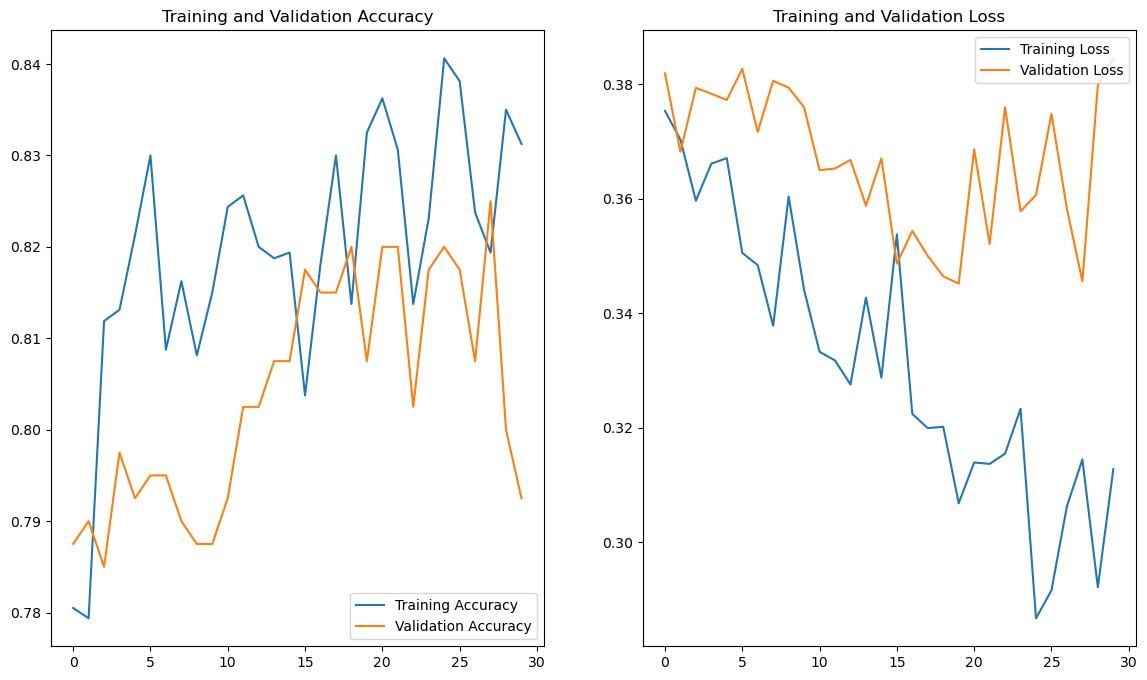

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
for k, v in history.history.items():
    print(f"{k}: {v}")
for x, y in train_data_gen:
    print(x.shape, y.shape)
    break


accuracy: [0.7262499928474426, 0.0, 0.7693750262260437, 0.0, 0.7981250286102295, 0.0, 0.809374988079071, 0.0, 0.8087499737739563, 0.0, 0.8168749809265137, 0.0, 0.8356249928474426, 0.0, 0.8224999904632568, 0.0, 0.8412500023841858, 0.0, 0.8374999761581421, 0.0, 0.8475000262260437, 0.0, 0.8481249809265137, 0.0, 0.8550000190734863, 0.0, 0.8537499904632568, 0.0, 0.8631250262260437, 0.0]
auc: [0.7812601327896118, 0.0, 0.8633585572242737, 0.0, 0.8778460621833801, 0.0, 0.8997265696525574, 0.0, 0.9000468254089355, 0.0, 0.8987804651260376, 0.0, 0.9075741767883301, 0.0, 0.9075827598571777, 0.0, 0.9193522930145264, 0.0, 0.9231625199317932, 0.0, 0.9303445816040039, 0.0, 0.9280772805213928, 0.0, 0.9331921339035034, 0.0, 0.9359843730926514, 0.0, 0.937401533126831, 0.0]
loss: [0.5958753228187561, 0.0, 0.45674729347229004, 0.0, 0.44023504853248596, 0.0, 0.3992176055908203, 0.0, 0.4010638892650604, 0.0, 0.39985451102256775, 0.0, 0.38682758808135986, 0.0, 0.3862699270248413, 0.0, 0.36209818720817566, 0.0